In [2]:
import numpy as np
import optuna
import sys
import joblib
import pandas as pd
import json
import matplotlib.pyplot as plt
import matplotlib
import lightgbm as lgb
import xgboost as xgb 
from sklearn.ensemble import RandomForestRegressor
import pickle
from sklearn.inspection import permutation_importance

### Data Loading

In [13]:
filepath = '../../split_income_data'

In [14]:
train = {}
for fold in range(0, 5):
    tdata_x85 = pd.read_csv(filepath + '/train/X_train_' + str(fold) + '_85.csv')
    tdata_x85 = tdata_x85.drop(columns=['Unnamed: 0'], axis=1)
    tdata_y85 = pd.read_csv(filepath + '/train/y_train_' + str(fold) + '_85.csv')
    tdata_y85 = tdata_y85.drop(columns=['Unnamed: 0'], axis=1)

    tdata_x95 = pd.read_csv(filepath + '/train/X_train_' + str(fold) + '_95.csv')
    tdata_x95 = tdata_x95.drop(columns=['Unnamed: 0'], axis=1)
    tdata_y95 = pd.read_csv(filepath + '/train/y_train_' + str(fold) + '_95.csv')
    tdata_y95 = tdata_y95.drop(columns=['Unnamed: 0'], axis=1)

    tdata_x1 = pd.read_csv(filepath + '/train/X_train_' + str(fold) + '_1.csv')
    tdata_x1 = tdata_x1.drop(columns=['Unnamed: 0'], axis=1)
    tdata_y1 = pd.read_csv(filepath + '/train/y_train_' + str(fold) + '_1.csv')
    tdata_y1 = tdata_y1.drop(columns=['Unnamed: 0'], axis=1)

    train[fold] = [tdata_x85, tdata_y85, tdata_x95, tdata_y95, tdata_x1, tdata_y1]

In [15]:
validation = {}
for fold in range(0, 5):
    vdata_x = pd.read_csv(filepath + '/val/X_val_' + str(fold) + '.csv')
    vdata_x = vdata_x.drop(columns=['Unnamed: 0'], axis=1)
    vdata_y = pd.read_csv(filepath + '/val/y_val_' + str(fold) + '.csv')
    vdata_y = vdata_y.drop(columns=['Unnamed: 0'], axis=1)
    validation[fold] = [vdata_x, vdata_y]

In [16]:
with open('../../split_income_models/countries_dict.pkl', 'rb') as f:
    countries_dict = pickle.load(f)

In [17]:
output_dir = '../../split_income_models'

### Random Forest

In [18]:
rf_imp_1_mean = []
rf_imp_95_mean = []
rf_imp_85_mean = []

rf_imp_1_std = []
rf_imp_95_std = []
rf_imp_85_std = []

for fold, fold_num in enumerate(['1', '2', '3', '4', '5']):
    for thresh, thresh_name in enumerate(['Threshold 85%', 'Threshold 95%', 'None']):

        if thresh == 0:
            name = '85'
        elif thresh == 1:
            name = '95'
        else: name = '1'

        train_input_data = train[fold][thresh * 2].copy()
        train_input_data['setting'] = train_input_data['setting'].map(countries_dict)

        val_input_data = validation[fold][0].copy()
        val_input_data['setting'] = val_input_data['setting'].map(countries_dict)
        val_input_data['setting'] = val_input_data['setting'].astype("category")
        val_label = validation[fold][1].copy()

        columns_needed = val_input_data.columns.intersection(train_input_data.columns)
        val_relevant_input = val_input_data[columns_needed]

        best_params = joblib.load(f"{output_dir}/random_forest/best_params_{fold}_{name}.pkl")

        loaded_model = RandomForestRegressor(**best_params)
        train_load = loaded_model.fit(train_input_data, train[fold][thresh * 2 + 1])
        feature_permute = permutation_importance(train_load, val_relevant_input, val_label, n_repeats=10, random_state=42)

        if thresh == 0:
            rf_imp_85_mean.append(feature_permute.importances_mean)
            rf_imp_85_std.append(feature_permute.importances_std)
        if thresh == 1:
            rf_imp_95_mean.append(feature_permute.importances_mean)
            rf_imp_95_std.append(feature_permute.importances_std)
        elif thresh == 2:
            rf_imp_1_mean.append(feature_permute.importances_mean)
            rf_imp_1_std.append(feature_permute.importances_std)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,),

### LightGBM

In [19]:
lgb_imp_1_mean = []
lgb_imp_95_mean = []
lgb_imp_85_mean = []

lgb_imp_1_std = []
lgb_imp_95_std = []
lgb_imp_85_std = []

for fold, fold_num in enumerate(['1', '2', '3', '4', '5']):
    for thresh, thresh_name in enumerate(['Threshold 85%', 'Threshold 95%', 'None']):

        if thresh == 0:
            name = '85'
        elif thresh == 1:
            name = '95'
        else: name = '1'

        train_input_data = train[fold][thresh * 2].copy()
        train_input_data['setting'] = train_input_data['setting'].astype("category")
        train_input_data.columns = train_input_data.columns.str.replace(r'[\"\[\]\{\}\\:,]', '', regex=True)
        train_label = train[fold][thresh * 2 + 1].copy()
        train_label.column = 'Maternal mortality ratio (national estimate per 100000 live births)'

        val_input_data = validation[fold][0].copy()
        val_input_data['setting'] = val_input_data['setting'].astype("category")
        val_input_data.columns = val_input_data.columns.str.replace(r'[\"\[\]\{\}\\:,]', '', regex=True)
        val_label = validation[fold][1].copy()
        val_label.column = 'Maternal mortality ratio (national estimate per 100000 live births)'

        val_data = val_input_data[train_input_data.columns].copy()

        best_params = joblib.load(f"{output_dir}/lightgbm/best_params_{fold}_{name}.pkl")

        loaded_model = lgb.LGBMRegressor(**best_params, verbosity = -1)

        train_load = loaded_model.fit(train_input_data, train_label)
        feature_permute = permutation_importance(train_load, val_data, val_label, n_repeats=10, random_state=42)

        if thresh == 0:
            lgb_imp_85_mean.append(feature_permute.importances_mean)
            lgb_imp_85_std.append(feature_permute.importances_std)
        if thresh == 1:
            lgb_imp_95_mean.append(feature_permute.importances_mean)
            lgb_imp_95_std.append(feature_permute.importances_std)
        elif thresh == 2:
            lgb_imp_1_mean.append(feature_permute.importances_mean)
            lgb_imp_1_std.append(feature_permute.importances_std)

In [20]:
len(lgb_imp_1_mean[4])

722

In [21]:
names1 = train[0][2 * 2].columns
names1

Index(['date',
       'Women and girls who use menstrual materials (% of women and girls ages 15-49 who had a menstrual period within the last year)',
       'setting',
       'Cause of death, by communicable diseases and maternal, prenatal and nutrition conditions, ages 5-14 (% of population ages 5-14)',
       'Cause of death, by communicable diseases and maternal, prenatal and nutrition conditions, ages 0-4 (% of population ages 0-4)',
       'Cause of death, by communicable diseases and maternal, prenatal and nutrition conditions, ages 60+ (% of population ages 60+)',
       'Women participating in own health care decisions (% of women age 15-49)',
       'Antiretroviral therapy coverage (% of adult males living with HIV)',
       'Cause of death, by communicable diseases and maternal, prenatal and nutrition conditions, ages 60+, male (% of male population ages 60+)',
       'Comprehensive correct knowledge of HIV/AIDS, ages 15-24, male (2 prevent ways and reject 3 misconceptions)'

### XGBoost

In [22]:
xgb_imp_1_mean = []
xgb_imp_95_mean = []
xgb_imp_85_mean = []

xgb_imp_1_std = []
xgb_imp_95_std = []
xgb_imp_85_std = []

for fold, fold_num in enumerate(['1', '2', '3', '4', '5']):
    for thresh, thresh_name in enumerate(['Threshold 85%', 'Threshold 95%', 'None']):

        if thresh == 0:
            name = '85'
        elif thresh == 1:
            name = '95'
        else: name = '1'

        train_input_data = train[fold][thresh * 2].copy()
        train_input_data['setting'] = train_input_data['setting'].astype("category")

        val_input_data = validation[fold][0].copy()
        val_input_data['setting'] = val_input_data['setting'].astype("category")
        val_label = validation[fold][1].copy()

        columns_needed = val_input_data.columns.intersection(train_input_data.columns)
        val_relevant_input = val_input_data[columns_needed]

        bp = joblib.load(f"{output_dir}/xgboost/best_params_{fold}_{name}.pkl")
        best_params = {'n_estimators' : bp['number_trees'], 'max_depth' : bp['max_tree_depth'], 'booster' : bp['boosting_type'], 'reg_alpha' : bp['l1_norm'], 
            'reg_lambda' : bp['l2_norm'], 'subsample' : bp['subsample'], 'learning_rate' : bp['learning_rate']}

        loaded_model = xgb.XGBRegressor(**best_params, enable_categorical=True)
        train_load = loaded_model.fit(train_input_data, train[fold][thresh * 2 + 1])
        feature_permute = permutation_importance(train_load, val_relevant_input, val_label, n_repeats=10, random_state=42)

        if thresh == 0:
            xgb_imp_85_mean.append(feature_permute.importances_mean)
            xgb_imp_85_std.append(feature_permute.importances_std)
        if thresh == 1:
            xgb_imp_95_mean.append(feature_permute.importances_mean)
            xgb_imp_95_std.append(feature_permute.importances_std)
        elif thresh == 2:
            xgb_imp_1_mean.append(feature_permute.importances_mean)
            xgb_imp_1_std.append(feature_permute.importances_std)

### Saving

In [23]:
with open('../../fs_frommodel_models/income/rf_imp_1_mean.pkl', 'wb') as f:
    pickle.dump(rf_imp_1_mean, f)
with open('../../fs_frommodel_models/income/rf_imp_95_mean.pkl', 'wb') as f:
    pickle.dump(rf_imp_95_mean, f)
with open('../../fs_frommodel_models/income/rf_imp_85_mean.pkl', 'wb') as f:
    pickle.dump(rf_imp_85_mean, f)

with open('../../fs_frommodel_models/income/rf_imp_1_std.pkl', 'wb') as f:
    pickle.dump(rf_imp_1_std, f)
with open('../../fs_frommodel_models/income/rf_imp_95_std.pkl', 'wb') as f:
    pickle.dump(rf_imp_95_std, f)
with open('../../fs_frommodel_models/income/rf_imp_85_std.pkl', 'wb') as f:
    pickle.dump(rf_imp_85_std, f)

In [24]:
with open('../../fs_frommodel_models/income/lgb_imp_1_mean.pkl', 'wb') as f:
    pickle.dump(lgb_imp_1_mean, f)
with open('../../fs_frommodel_models/income/lgb_imp_95_mean.pkl', 'wb') as f:
    pickle.dump(lgb_imp_95_mean, f)
with open('../../fs_frommodel_models/income/lgb_imp_85_mean.pkl', 'wb') as f:
    pickle.dump(lgb_imp_85_mean, f)

with open('../../fs_frommodel_models/income/lgb_imp_1_std.pkl', 'wb') as f:
    pickle.dump(lgb_imp_1_std, f)
with open('../../fs_frommodel_models/income/lgb_imp_95_std.pkl', 'wb') as f:
    pickle.dump(lgb_imp_95_std, f)
with open('../../fs_frommodel_models/income/lgb_imp_85_std.pkl', 'wb') as f:
    pickle.dump(lgb_imp_85_std, f)

In [25]:
with open('../../fs_frommodel_models/income/xgb_imp_1_mean.pkl', 'wb') as f:
    pickle.dump(xgb_imp_1_mean, f)
with open('../../fs_frommodel_models/income/xgb_imp_95_mean.pkl', 'wb') as f:
    pickle.dump(xgb_imp_95_mean, f)
with open('../../fs_frommodel_models/income/xgb_imp_85_mean.pkl', 'wb') as f:
    pickle.dump(xgb_imp_85_mean, f)

with open('../../fs_frommodel_models/income/xgb_imp_1_std.pkl', 'wb') as f:
    pickle.dump(xgb_imp_1_std, f)
with open('../../fs_frommodel_models/income/xgb_imp_95_std.pkl', 'wb') as f:
    pickle.dump(xgb_imp_95_std, f)
with open('../../fs_frommodel_models/income/xgb_imp_85_std.pkl', 'wb') as f:
    pickle.dump(xgb_imp_85_std, f)

### Comparisons

#### Feature Intersections

In [ ]:
lgb_avg_1 = np.mean(lgb_imp_1_mean, axis=0)
lgb_std_1 = np.mean(lgb_imp_1_std, axis=0)

names1 = train[0][2 * 2].columns

# Wrap in DataFrame
lgb_avg_1_df = pd.DataFrame({
    'Feature': names1,
    'Avg_Permutation_Importance LGBM Threshold = None': lgb_avg_1,
    'Std' : lgb_std_1
}).sort_values(by='Avg_Permutation_Importance LGBM Threshold = None', ascending=False)

lgb_1_imp_pos = lgb_avg_1_df[lgb_avg_1_df['Avg_Permutation_Importance LGBM Threshold = None'] - lgb_avg_1_df['Std'] > 0]
lgb_1_imp_pos_big = lgb_1_imp_p3os[lgb_avg_1_df['Avg_Permutation_Importance LGBM Threshold = None'] > 0.001]
print(lgb_1_imp_pos_big.shape)
lgb_1_imp_pos_big
#lgb_avg_1_df.plot.bar(x = 'Feature', yerr='Std', figsize=(15, 8))

(34, 3)


/var/folders/jd/0gmk2m5x1cl2hh0v_hsx43q40000gn/T/ipykernel_5968/4216900893.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  lgb_1_imp_pos_big = lgb_1_imp_pos[lgb_avg_1_df['Avg_Permutation_Importance LGBM Threshold = None'] > 0.001]


,Feature,Avg_Permutation_Importance LGBM Threshold = None,Std
637,"Self-employed, total (% of total employment) (...",0.137383,0.012014
641,Vulnerable employment (% of total employment) ...,0.044990,0.005101
137,"Mortality rate, adult, female (per 1,000 femal...",0.038884,0.006079
116,"Stillbirth rate (per 1,000 total births)",0.034563,0.003921
139,"Fertility rate, total (births per woman)",0.014932,0.004015
16,"Survival to age 65, female (% of cohort)",0.013281,0.003467
168,"Contraceptive prevalence, any method (% of mar...",0.013141,0.002337
188,Teenage mothers (% of women ages 15-19 who hav...,0.007613,0.001263
642,Vulnerable employment (% of total employment) ...,0.005648,0.001692
93,"Adolescent fertility rate (births per 1,000 wo...",0.004223,0.002145


In [27]:
rf_avg_1 = np.mean(rf_imp_1_mean, axis=0)
rf_std_1 = np.mean(rf_imp_1_std, axis=0)
rf_avg_1_df = pd.DataFrame({
    'Feature': names1,
    'Avg_Permutation_Importance RF Threshold = None': rf_avg_1,
    'Std' : rf_std_1
}).sort_values(by='Avg_Permutation_Importance RF Threshold = None', ascending=False)
rf_1_imp_pos = rf_avg_1_df[rf_avg_1_df['Avg_Permutation_Importance RF Threshold = None'] - rf_avg_1_df['Std'] > 0]
rf_1_imp_pos_big = rf_1_imp_pos[rf_avg_1_df['Avg_Permutation_Importance RF Threshold = None'] > 0.001]
print(rf_1_imp_pos_big.shape)
rf_1_imp_pos_big

(32, 3)


/var/folders/jd/0gmk2m5x1cl2hh0v_hsx43q40000gn/T/ipykernel_5968/1706408803.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  rf_1_imp_pos_big = rf_1_imp_pos[rf_avg_1_df['Avg_Permutation_Importance RF Threshold = None'] > 0.001]


,Feature,Avg_Permutation_Importance RF Threshold = None,Std
641,Vulnerable employment (% of total employment) ...,0.069730,0.008199
643,Wage and salaried workers (% of total employme...,0.048269,0.006206
637,"Self-employed, total (% of total employment) (...",0.046755,0.005651
16,"Survival to age 65, female (% of cohort)",0.019779,0.003016
137,"Mortality rate, adult, female (per 1,000 femal...",0.016270,0.003404
139,"Fertility rate, total (births per woman)",0.010608,0.003330
116,"Stillbirth rate (per 1,000 total births)",0.008269,0.001445
168,"Contraceptive prevalence, any method (% of mar...",0.003914,0.000612
642,Vulnerable employment (% of total employment) ...,0.002513,0.000760
93,"Adolescent fertility rate (births per 1,000 wo...",0.002466,0.000606


In [28]:
xgb_avg_1 = np.mean(xgb_imp_1_mean, axis=0)
xgb_std_1 = np.mean(xgb_imp_1_std, axis=0)
xgb_avg_1_df = pd.DataFrame({
    'Feature': names1,
    'Avg_Permutation_Importance xgb Threshold = None': xgb_avg_1,
    'Std' : xgb_std_1
}).sort_values(by='Avg_Permutation_Importance xgb Threshold = None', ascending=False)
xgb_1_imp_pos = xgb_avg_1_df[xgb_avg_1_df['Avg_Permutation_Importance xgb Threshold = None'] - xgb_avg_1_df['Std'] > 0]
xgb_1_imp_pos_big = xgb_1_imp_pos[xgb_avg_1_df['Avg_Permutation_Importance xgb Threshold = None'] > 0.001]
print(xgb_1_imp_pos_big.shape)
xgb_1_imp_pos_big

(3, 3)


/var/folders/jd/0gmk2m5x1cl2hh0v_hsx43q40000gn/T/ipykernel_5968/2781861880.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xgb_1_imp_pos_big = xgb_1_imp_pos[xgb_avg_1_df['Avg_Permutation_Importance xgb Threshold = None'] > 0.001]


,Feature,Avg_Permutation_Importance xgb Threshold = None,Std
2,setting,0.003638,0.003098
637,"Self-employed, total (% of total employment) (...",0.001315,0.000074
16,"Survival to age 65, female (% of cohort)",0.001052,0.000118


In [29]:
rf_lgb_1_intersection = set(lgb_1_imp_pos_big['Feature']) & set(rf_1_imp_pos_big['Feature'])
len(rf_lgb_1_intersection)

16

In [30]:
rf_lgb_1_intersection

{'Adolescent fertility rate (births per 1,000 women ages 15-19)',
 'Contraceptive prevalence, any method (% of married women ages 15-49)',
 'Demand for family planning satisfied by any methods (% of married women with demand for family planning)',
 'Employment in industry (% of total employment) (modeled ILO estimate) male',
 'Fertility rate, total (births per woman)',
 'Mortality rate attributed to unintentional poisoning (per 100,000 population)',
 'Mortality rate, adult, female (per 1,000 female adults)',
 'Mortality rate, adult, male (per 1,000 male adults)',
 'People practicing open defecation (% of population)',
 'People practicing open defecation, rural (% of rural population)',
 'Self-employed, total (% of total employment) (modeled ILO estimate) female',
 'Stillbirth rate (per 1,000 total births)',
 'Survival to age 65, female (% of cohort)',
 'Vulnerable employment (% of total employment) (modeled ILO estimate) female',
 'Vulnerable employment (% of total employment) (modeled

In [31]:
rf_only = []
for feature_name in rf_1_imp_pos_big['Feature']:
    if feature_name not in rf_lgb_1_intersection:
        rf_only.append(feature_name)

rf_only

['Wage and salaried workers (% of total employment) (modeled ILO estimate) female',
 "Women's share of population ages 15+ living with HIV (%)",
 'Births attended by skilled health staff (% of total)',
 'Knowledge of any method of contraception (% of all women ages 15-49)',
 'Self-employed, total (% of total employment) (modeled ILO estimate) male',
 'Contraceptive prevalence, any modern method (% of married women ages 15-49)',
 'Mortality rate attributed to unintentional poisoning, female (per 100,000 female population)',
 'Prevalence of underweight, weight for age, male (% of children under 5)',
 'Unmet need for contraception (% of married women ages 15-49)',
 'Mortality rate, under-5 (per 1,000 live births)',
 'Survival to age 65, male (% of cohort)',
 'Employment in agriculture (% of total employment) (modeled ILO estimate) female',
 'Knowledge of any modern method of contraception (% of married women ages 15-49)',
 'Prevalence of underweight, weight for age (% of children under 5)

In [32]:
lgb_only = []
for feature_name in lgb_1_imp_pos_big['Feature']:
    if feature_name not in rf_lgb_1_intersection:
        lgb_only.append(feature_name)

lgb_only

['Teenage mothers (% of women ages 15-19 who have had children or are currently pregnant)',
 'Condom use at last high-risk sex, adult male (% ages 15-49)',
 'Mortality rate, infant (per 1,000 live births)',
 'Prevalence of anemia among pregnant women (%)',
 'Prevalence of overweight, male (% of male adults)',
 'Incidence of HIV, ages 15-24 (per 1,000 uninfected population ages 15-24)',
 'Pregnant women receiving prenatal care (%)',
 'Total alcohol consumption per capita, female (liters of pure alcohol, projected estimates, female 15+ years of age)',
 'Mortality rate, under-5, female (per 1,000 live births)',
 'Prevalence of HIV, female (% ages 15-24)',
 'Antiretroviral therapy coverage for PMTCT (% of pregnant women living with HIV)',
 'Primary completion rate (% of relevant age group) male',
 'Prevalence of HIV, male (% ages 15-24)',
 'Pregnant women receiving prenatal care of at least four visits (% of pregnant women)',
 'Employment in industry (% of total employment) (modeled ILO es

#### Visualisations

In [33]:
lgb_to_plot = lgb_1_imp_pos_big[lgb_1_imp_pos_big['Feature'].isin(rf_lgb_1_intersection)]
rf_to_plot = rf_1_imp_pos_big[rf_1_imp_pos_big['Feature'].isin(rf_lgb_1_intersection)]

lgb_to_plot.columns = ['Feature', 'LightGBM', 'Std LightGBM']
rf_to_plot.columns = ['Feature', 'RF', 'Std RF']

data_to_plot = lgb_to_plot.merge(rf_to_plot, on='Feature')
data_to_plot

,Feature,LightGBM,Std LightGBM,RF,Std RF
0,"Self-employed, total (% of total employment) (...",0.137383,0.012014,0.046755,0.005651
1,Vulnerable employment (% of total employment) ...,0.044990,0.005101,0.069730,0.008199
2,"Mortality rate, adult, female (per 1,000 femal...",0.038884,0.006079,0.016270,0.003404
3,"Stillbirth rate (per 1,000 total births)",0.034563,0.003921,0.008269,0.001445
4,"Fertility rate, total (births per woman)",0.014932,0.004015,0.010608,0.003330
5,"Survival to age 65, female (% of cohort)",0.013281,0.003467,0.019779,0.003016
6,"Contraceptive prevalence, any method (% of mar...",0.013141,0.002337,0.003914,0.000612
7,Vulnerable employment (% of total employment) ...,0.005648,0.001692,0.002513,0.000760
8,"Adolescent fertility rate (births per 1,000 wo...",0.004223,0.002145,0.002466,0.000606
9,"People practicing open defecation, rural (% of...",0.003870,0.001046,0.001082,0.000230


In [34]:
data_to_plot[['Std LightGBM', 'Std RF']].to_numpy().T

array([[0.01201407, 0.00510064, 0.00607903, 0.00392096, 0.0040146 ,
        0.00346696, 0.00233747, 0.00169157, 0.00214474, 0.00104617,
        0.00095299, 0.0008592 , 0.00094173, 0.00052847, 0.00075959,
        0.00055026],
       [0.00565138, 0.00819926, 0.00340443, 0.00144456, 0.00333002,
        0.0030155 , 0.00061202, 0.00076034, 0.00060647, 0.00022974,
        0.00059395, 0.00045512, 0.00060328, 0.00057178, 0.00020645,
        0.00051466]])

Text(0.5, 1.0, 'Feature Importances with Error Bars (LightGBM vs RF)')

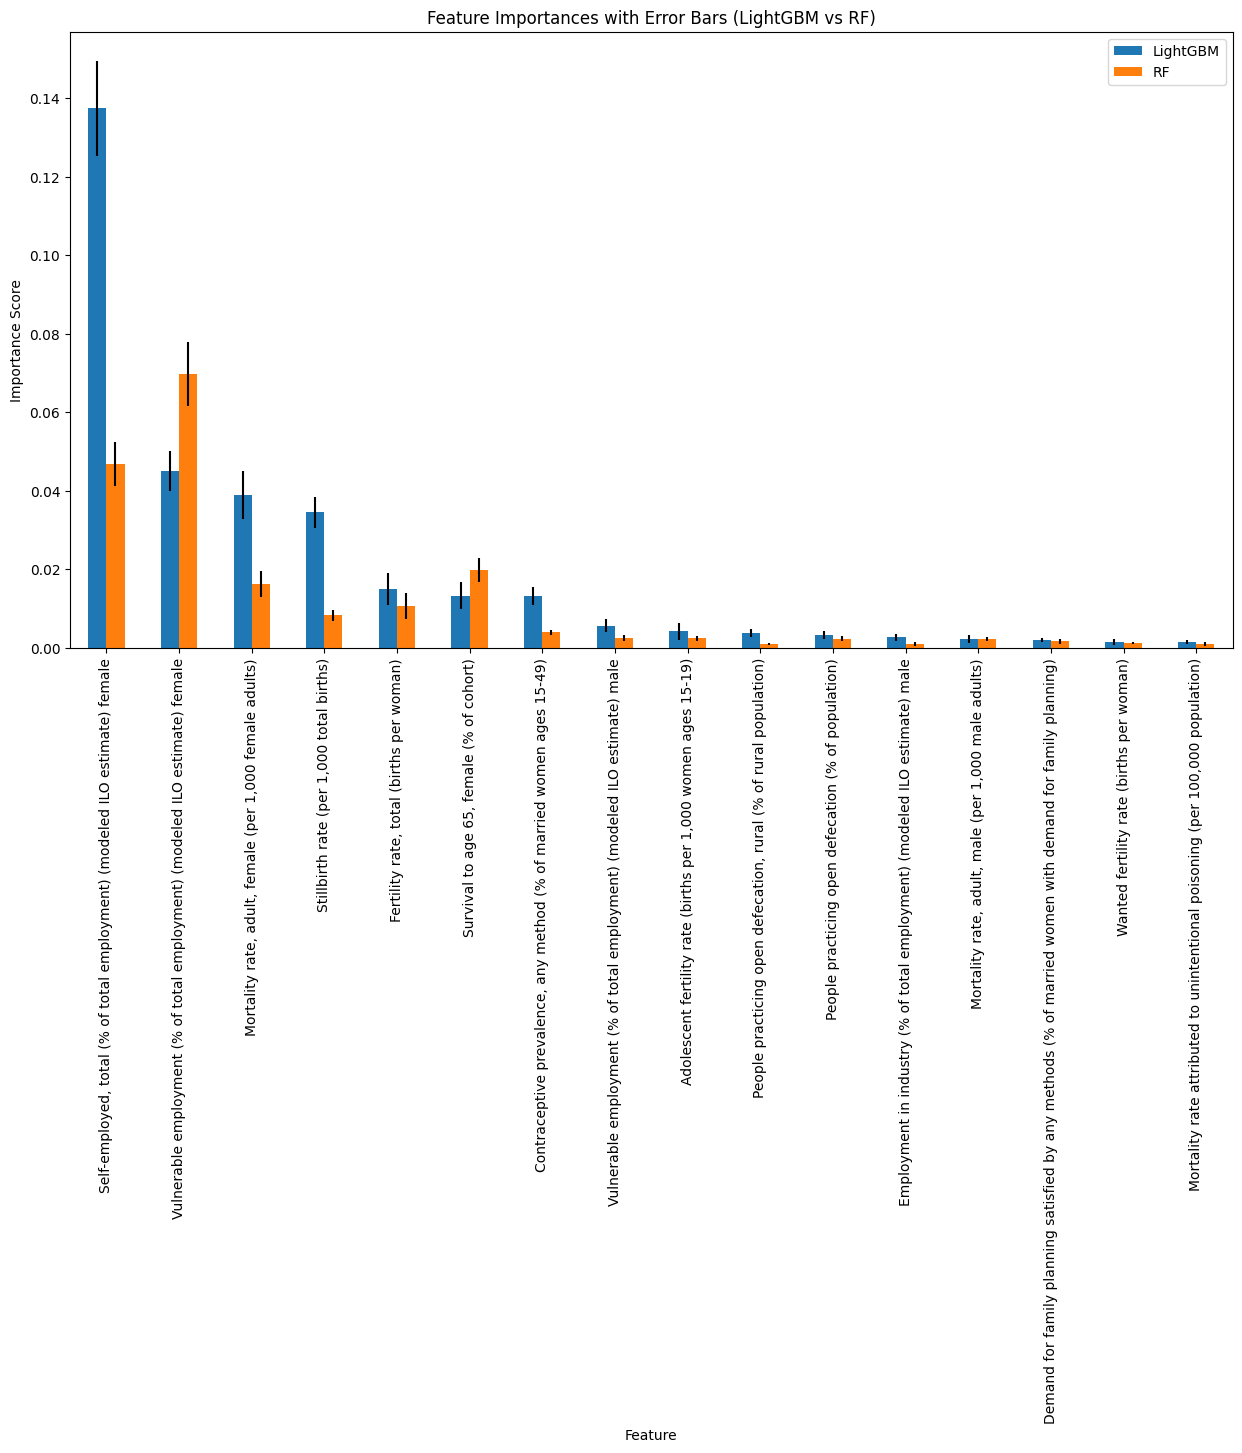

In [35]:
data_to_plot.index = data_to_plot['Feature']
data_to_plot[['LightGBM', 'RF']].plot.bar(figsize=(15, 8), yerr=data_to_plot[['Std LightGBM', 'Std RF']].to_numpy().T)
plt.ylabel("Importance Score")
plt.title("Feature Importances with Error Bars (LightGBM vs RF)")